In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive

/content/drive/MyDrive


In [3]:
# !pip install sentencepiece
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 90.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 109.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 83.4 MB/s eta 0:00:00
  Preparing metadat

In [4]:
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
import os
import json

In [5]:
import os
import json
import re
from zipfile import ZipFile

cond = re.compile('[가-힣]+')

def get_data_from_zip(zip_name):
    zip_file_path = '/content/drive/MyDrive/jolnon/' + zip_name + '.zip'
    extract_path = '/content/' + zip_name

    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    result = []
    for name in os.listdir(path=extract_path):
        file_path = os.path.join(extract_path, name)
        if os.path.isdir(file_path):
            for name in os.listdir(path=file_path):
                with open(file_path + '/' + name, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    valid = []
                    for d in data['content'].split('\n'):
                        res = []
                        for word in d.split(' '):
                            if cond.match(word) != None:
                                res.append(word)
                        d = ' '.join(res)
                        if d and not d.replace(' ', '').isdecimal():
                            valid.append(d)
                    result.append('\n'.join([data['title']] + valid))
        else:
            with open(extract_path + '/' + name, 'r', encoding='utf-8') as f:
                data = json.load(f)
                valid = []
                for d in data['content'].split('\n'):
                    res = []
                    for word in d.split(' '):
                        if cond.match(word) != None:
                            res.append(word)
                    d = ' '.join(res)
                    if d and not d.replace(' ', '').isdecimal():
                        valid.append(d)
                result.append('\n'.join([data['title']] + valid))
    return result


In [6]:
import random
random.seed(42)
galleries = ['animal','tree']
dataset = []
for e in galleries:
  dataset.append([get_data_from_zip(e)])
cocktail = []
for data in dataset:
  for sen in data:
    cocktail+=sen

In [7]:
def remove_words(sentence, word):
    return ' '.join([w.replace(word, '') for w in sentence.split()])
    # return ' '.join([w for w in sentence.split() if w != word])
stopwords = ['-dc', 'official', 'App', '이미지' ,'순서','저장','.jpg','.png','.txt','.gif']#['ㅋㅋ', 'ex', '나는', 'on', '이미지', '순서', '오늘', '일단', 'and', '이야', '그리고', '내일', '그냥', '000', '조금', '살짝', 'ㅇㅇ', 'ㅈㄱㄴ', '있음', '이거', '내가', '칵하하하', '칵하핫', '근데', '지듣노', 'youtube ', '야스중', '우흥', '한다', 'ㅎㅎ', 'ㅠㅠ', '로오오오오오옹', '하고', '아침', '것도', '추천', '혹시', '새낀데', '같다']
for i in range(len(cocktail)):
  for j in range(len(stopwords)):
    cocktail[i] = remove_words(cocktail[i],stopwords[j])

In [8]:
import collections

def remove_top_n_words(data, n):
    words = [word for sentence in data for word in sentence.split(' ')]
    word_count = collections.Counter(words)
    top_n_words = [word for word, _ in word_count.most_common(n)]
    for i in range(len(data)):
        for word in top_n_words:
            if word=='':
                continue
            data[i] = remove_words(data[i], word)
    return data

def remove_empty_sentences(cocktail, real_labels):
  indices = [i for i, sentence in enumerate(cocktail) if sentence.strip() != '']
  cocktail = [cocktail[i] for i in indices]
  real_labels = [real_labels[i] for i in indices]
  return cocktail, real_labels


In [9]:
real_labels = []
for i in range(len(dataset)):
  real_labels += [i] * len(dataset[i][0])
cocktail = remove_top_n_words(cocktail, 0)
cocktail, real_labels = remove_empty_sentences(cocktail, real_labels)

In [ ]:
# !pip install transformers
# from transformers import AutoModel, AutoTokenizer
# model = AutoModel.from_pretrained("klue/roberta-large")
# tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

# model = AutoModel.from_pretrained("klue/bert-base")
# tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

In [10]:
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
bertopic_model_embed_token = BERTopic(language='multilingual',
                          nr_topics=100,
                          # ctfidf_model=ctfidf_model,
                          top_n_words=1)
# bertopic_model_embed_token = BERTopic(embedding_model=model,
#                                       vectorizer_model=vectorizer,
#                                       ctfidf_model=ctfidf_model,
#                                       nr_topics=100,
#                                       top_n_words=1,
#                                       calculate_probabilities=False)
topics, _ = bertopic_model_embed_token.fit_transform(cocktail)

In [11]:
topic_info = bertopic_model_embed_token.get_topic_info()
number_of_topics = len(topic_info) - 1
print(f"생성된 주제의 수: {number_of_topics}")
lst = []
for index, row in topic_info.iterrows():
    topic_num = row['Topic']
    if topic_num != -1:
        topic_name = row['Name']
        pure_topic_name = "_".join(topic_name.split("_")[1:])
        lst.append(pure_topic_name)
# for i in lst:
#   print(i)

생성된 주제의 수: 99


In [12]:
### Reducing outliers
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="c-tf-idf", threshold=0.1)
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="distributions")

In [13]:
hierarchical_topics = bertopic_model_embed_token.hierarchical_topics(cocktail)

100%|██████████| 98/98 [00:00<00:00, 106.83it/s]


In [ ]:
# Hierarchical topics
# linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
# hierarchical_topics = bertopic_model_embed_token.hierarchical_topics(cocktail, linkage_function=linkage_function)

In [14]:
bertopic_model_embed_token.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [15]:
# 주제, 분기점 별 클러스터 구성 라벨 수
verify = True
table = [[0 for r in range(2)] for t in range(max([int(x) for x in hierarchical_topics['Parent_ID']]) + 1)]
if verify:
  for j in range(number_of_topics):
    for i in range(len(topics)):
      if topics[i]==j:
        table[j][real_labels[i]]+=1
  for j in range(number_of_topics, len(table)):
    row = hierarchical_topics[hierarchical_topics['Parent_ID'] == str(j)].iloc[0]
    left, right = int(row['Child_Left_ID']), int(row['Child_Right_ID'])
    for i in range(len(table[0])):
      table[j][i] += table[left][i] + table[right][i]

In [16]:
df = hierarchical_topics
selected_topics_ids = set()
for index, row in df[df['Distance'] >= 1].iterrows():
    left_child = df[df['Parent_ID'] == row['Child_Left_ID']]
    if not left_child.empty and left_child.iloc[0]['Distance'] < 1:
        selected_topics_ids.add(row['Child_Left_ID'])

    right_child = df[df['Parent_ID'] == row['Child_Right_ID']]
    if not right_child.empty and right_child.iloc[0]['Distance'] < 1:
        selected_topics_ids.add(row['Child_Right_ID'])
selected_topics_ids = list(selected_topics_ids)

In [17]:
post_counts = [0 for i in range(number_of_topics)]
for i in range(len(post_counts)):
    post_counts[i] = topics.count(i)

In [18]:
selected_topic_names=[]
for topic_id in selected_topics_ids:
    topic_name = df[df['Parent_ID'] == topic_id]['Parent_Name'].iloc[0]
    selected_topic_names.append(topic_name)

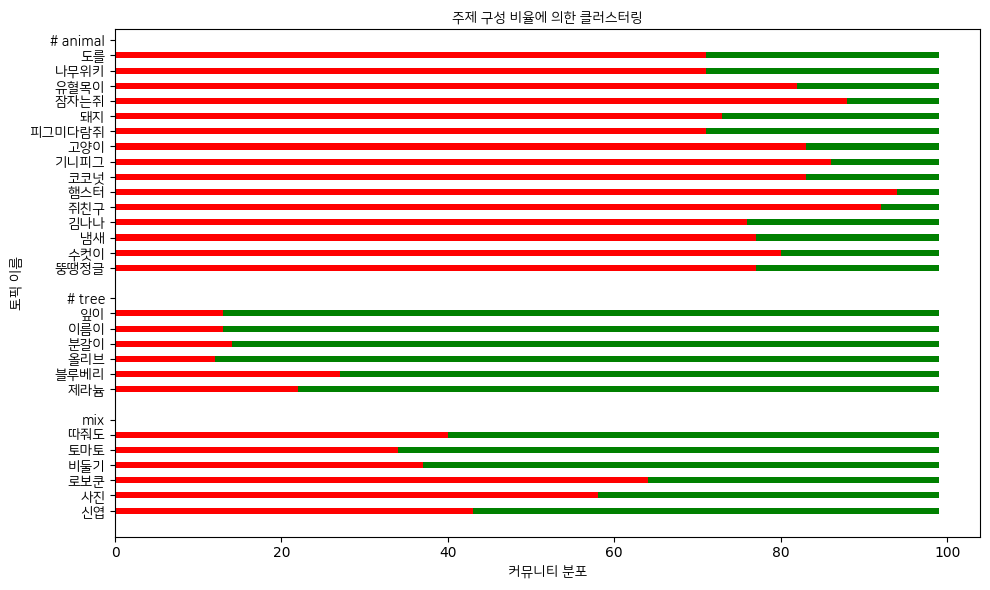

animal: ['도를', '나무위키', '유혈목이', '잠자는쥐', '돼지', '피그미다람쥐', '고양이', '기니피그', '코코넛', '햄스터', '쥐친구', '김나나', '냄새', '수컷이', '뚱땡정글'] - 6630
tree: ['잎이', '이름이', '분갈이', '올리브', '블루베리', '제라늄'] - 8407
mix: ['따줘도', '토마토', '비둘기', '로보쿤', '사진', '신엽'] - 4008


In [19]:
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

def clusterByRatio(th, table, selected_topics_ids, selected_topic_names, galleries, post_counts):
    selected_topic_counts = [[0, 0] for _ in range(len(selected_topics_ids))]
    for i in range(len(selected_topics_ids)):
        selected_topic_counts[i][0] += table[int(selected_topics_ids[i])][0]
        selected_topic_counts[i][1] += table[int(selected_topics_ids[i])][1]
    dic = dict()
    n_clusters = len(galleries) + 1
    clusters = [[] for _ in range(n_clusters)]
    name2idx = dict()
    for i in range(len(selected_topics_ids)):
        name2idx[selected_topic_names[i]] = int(selected_topics_ids[i])
        ratio = selected_topic_counts[i][0] / sum(selected_topic_counts[i])
        if ratio > (1 - th):
            clusters[0].append(selected_topic_names[i])
        elif ratio < th:
            clusters[1].append(selected_topic_names[i])
        else:
            clusters[2].append(selected_topic_names[i])
        dic[selected_topic_names[i]]=[ratio, 1-ratio, ]
    font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=10)
    plt.rcParams["font.family"] = fontprop.get_name()
    plt.rcParams['axes.unicode_minus'] = False

    fig, ax = plt.subplots(figsize=(10, 6))

    y_positions = []
    y_labels = []

    current_y = 0
    bar_width = 0.4

    for index, cluster in enumerate(clusters):
        y_positions.append(current_y)
        cluster_name ='# ' + galleries[index] if index<len(galleries) else 'mix'
        y_labels.append(cluster_name)
        for topic in cluster:
            current_y -= 1
            y_positions.append(current_y)
            y_labels.append(topic)
            ax.barh(current_y, int(dic[topic][0]*100), color='r', height=bar_width, label=topic)
            ax.barh(current_y, int(dic[topic][1]*100), color='g', left=int(dic[topic][0]*100), height=bar_width)
        current_y -= 2

    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels, fontproperties=fontprop)
    ax.set_xlabel('커뮤니티 분포', fontproperties=fontprop)
    plt.title("주제 구성 비율에 의한 클러스터링", fontproperties=fontprop)
    plt.ylabel("토픽 이름", fontproperties=fontprop)

    plt.tight_layout()
    plt.show()

    for idx, r in enumerate(clusters):
        name = galleries[idx] if idx < len(galleries) else 'mix'
        val = sum([sum(table[name2idx[x]]) for x in r])
        print(f'{name}: {r} - {val}')

    plt.show()
    return clusters

threshold = 0.3
cRatio =[]
if verify:
  cRatio = clusterByRatio(threshold, table, selected_topics_ids, selected_topic_names, galleries, post_counts)


In [ ]:
# !pip install fasttext
# import fasttext
# from sklearn.cluster import KMeans
# import numpy as np
# from gensim import models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199771 sha256=2d1f659999994947c4daae6427e2e4765b91b35cfd6e75feff7e9a6997c15775
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
# model_path = '/content/drive/MyDrive/jolnon/cc.ko.100.bin'
# m_fasttext = models.fasttext.load_facebook_model(model_path)

ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa1\x9c'; replacing invalid characters, using '\\xed\\xa1\\x9c'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb0\x80'; replacing invalid characters, using '\\xed\\xb0\\x80'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa7\x80'; replacing invalid characters, using '\\xed\\xa7\\x80'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb8\xb0'; replacing invalid characters, using '\\xed\\xb8\\xb0'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa0\x9c'; replacing invalid characters, using '\\xed\\xa0\\x9c'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa6\xac'; replacing invalid characters, using '\\xed\\xa6\\xac'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb3\xb5'; replacing invalid characters, using '\\xed\\xb

In [ ]:
# embeddings = [m_fasttext.wv[selected_topic_names[i]] for i in range(len(selected_topic_names))]
# embed_ids = [selected_topics_ids[i] for i in range(len(selected_topic_names))]
# embeddings = np.array(embeddings)

In [20]:
for i in range(len(selected_topic_names)):
  print(selected_topic_names[i], selected_topics_ids[i])

따줘도 167
잎이 169
도를 158
토마토 159
이름이 125
나무위키 163
분갈이 161
올리브 138
유혈목이 135
잠자는쥐 160
돼지 166
피그미다람쥐 168
고양이 156
비둘기 162
기니피그 124
코코넛 133
블루베리 165
햄스터 130
로보쿤 126
사진 115
쥐친구 111
제라늄 164
김나나 121
냄새 148
수컷이 123
뚱땡정글 119
신엽 154


In [21]:
hierarchical_topics

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
97,196,햄스터,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",194,식물,195,햄스터,1.493739
96,195,햄스터,"[0, 1, 6, 10, 12, 14, 15, 16, 17, 24, 25, 26, ...",193,너무,189,햄스터,1.286537
95,194,식물,"[2, 3, 4, 5, 7, 8, 9, 11, 13, 18, 19, 20, 21, ...",125,이름이,169,잎이,1.260102
94,193,너무,"[1, 6, 10, 12, 14, 15, 24, 25, 27, 28, 32, 35,...",126,로보쿤,192,고양이,1.172663
93,192,고양이,"[6, 10, 12, 14, 15, 24, 25, 27, 28, 35, 38, 40...",191,고양이,190,나무위키,1.110297
...,...,...,...,...,...,...,...,...
4,103,햄스터,"[0, 16]",16,핸들링,0,햄스터,0.766788
3,102,로보쿤,"[1, 32]",32,로보쿤,1,로보쿤,0.752982
2,101,잎이,"[2, 3, 4]",100,잎이,2,꽃이,0.721569
1,100,잎이,"[3, 4]",4,물을,3,잎이,0.626848


['따줘도', '잎이', '토마토', '분갈이', '올리브', '코코넛', '블루베리', '제라늄', '신엽']
['유혈목이', '잠자는쥐', '돼지', '피그미다람쥐', '고양이', '비둘기', '기니피그', '햄스터', '로보쿤', '쥐친구', '수컷이', '뚱땡정글']
['도를', '이름이', '나무위키', '사진', '김나나', '냄새']
{'name': 'Cluster #1', 'value': 8988, 'distribution': [21.484201157098354, 78.51579884290165], 'topics': [{'name': '따줘도', 'value': 284, 'distribution': [40.140845070422536, 59.859154929577464]}, {'name': '잎이', 'value': 6192, 'distribution': [13.598191214470285, 86.40180878552971]}, {'name': '토마토', 'value': 282, 'distribution': [34.39716312056738, 65.60283687943263]}, {'name': '분갈이', 'value': 377, 'distribution': [14.588859416445624, 85.41114058355437]}, {'name': '올리브', 'value': 144, 'distribution': [12.5, 87.5]}, {'name': '코코넛', 'value': 446, 'distribution': [83.6322869955157, 16.367713004484305]}, {'name': '블루베리', 'value': 319, 'distribution': [27.272727272727273, 72.72727272727273]}, {'name': '제라늄', 'value': 318, 'distribution': [22.641509433962263, 77.35849056603773]}, {'name': '신엽', 'value'

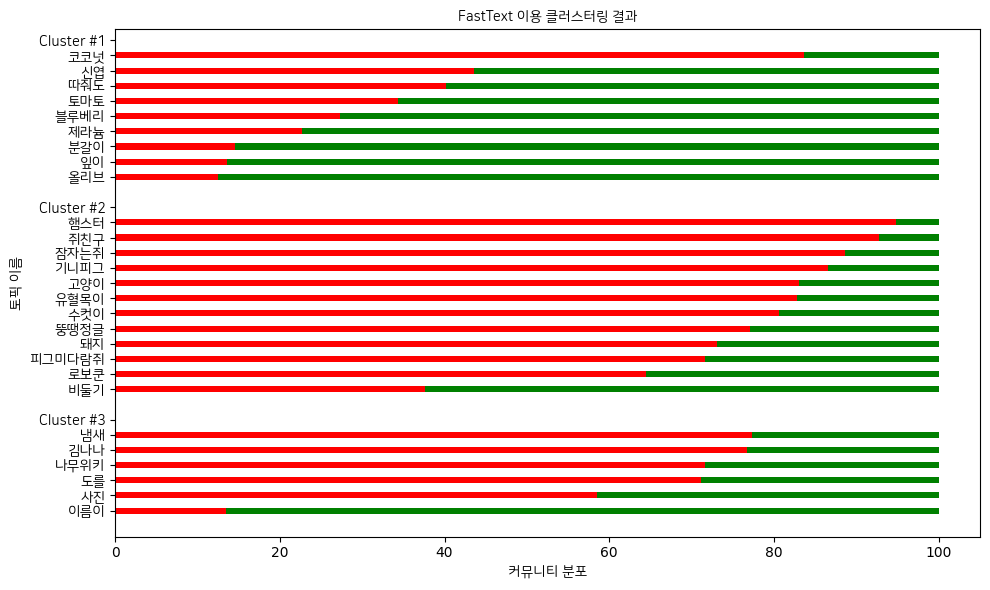

In [22]:
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

def clusterByHand(table, selected_topics_ids, selected_topic_names, galleries, post_counts):
  selected_topic_counts = [[0, 0] for _ in range(len(selected_topics_ids))]
  for i in range(len(selected_topics_ids)):
    selected_topic_counts[i][0] += table[int(selected_topics_ids[i])][0]
    selected_topic_counts[i][1] += table[int(selected_topics_ids[i])][1]
  dic = dict()
  n_clusters = len(galleries) + 1
  # clusters = [['뿌리가',	'꽃이',	'제라늄',	'코코넛',	'식물',	'토마토',	'알로카시아',	'신엽',	'버섯',	'아몬드'],
  #               ['기니피그',	'피그미다람쥐',	'잠자는쥐',	'고양이',	'유혈목이',	'쥐친구',	'돼지',	'햄스터',	'로보쿤'],
  #               ['우리집',	'냄새',	'사진',	'이거',	'이름이',	'에어컨',	'서울',	'일본',	'나무위키']]
  idx2name = dict(zip(selected_topics_ids,selected_topic_names))
  name2idx = dict(zip(selected_topic_names,selected_topics_ids))
  clustered_topics_name = ['따줘도 잎이 토마토 분갈이 올리브 코코넛 블루베리 제라늄 신엽'.split(),
                '유혈목이 잠자는쥐 돼지 피그미다람쥐 고양이 비둘기 기니피그 햄스터 로보쿤 쥐친구 수컷이 뚱땡정글'.split(),
                '도를 이름이 나무위키 사진 김나나 냄새'.split()]
  clustered_topics_count = [[] for _ in range(n_clusters)]
  clustered_topics = [[] for _ in range(n_clusters)]
  for i in range(len(clustered_topics_name)):
    for ele in clustered_topics_name[i]:
      clustered_topics[i].append(name2idx[ele])
  for r in clustered_topics_name:
    print(r)
  cluster_sums = []
  for idx, cluster in enumerate(clustered_topics):
    total_sum = 0
    for parent_id in cluster:
      row = hierarchical_topics[hierarchical_topics['Parent_ID'] == parent_id].iloc[0]
      topic_ids = row['Topics']
      cluster_sum = sum(post_counts[topic_id] for topic_id in topic_ids)
      clustered_topics_count[idx].append(cluster_sum)
      total_sum += cluster_sum
    cluster_sums.append(total_sum)
  if verify:
    clustered_count = [[0, 0] for _ in range(n_clusters)]
    for i in range(n_clusters):
      for j in clustered_topics[i]:
        clustered_count[i][0] += table[int(j)][0]
        clustered_count[i][1] += table[int(j)][1]

    for i in range(n_clusters):
      l, r = clustered_count[i][0], clustered_count[i][1]
      # print(f'Cluster #{i+1}: ({l + r}) - [{100 * l / (l + r):.2F}, {100 * r / (l + r):.2F}]')
      for j in range(len(clustered_topics[i])):
        k = clustered_topics[i][j]
        l, r = table[int(k)][0], table[int(k)][1]
        # print(f'\t- {clustered_topics_name[i][j]} ({l + r}): [{100 * l / (l + r):.2F}, {100 * r / (l + r):.2F}]')
    clusters = []

    for i in range(n_clusters):
      cluster_info = {}
      l, r = clustered_count[i][0], clustered_count[i][1]
      cluster_info['name'] = f'Cluster #{i+1}'
      cluster_info['value'] = l + r
      cluster_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]

      topics_list = []
      for j in range(len(clustered_topics[i])):
        topic_info = {}
        k = clustered_topics[i][j]
        l, r = table[int(k)][0], table[int(k)][1]
        topic_info['name'] = clustered_topics_name[i][j]
        topic_info['value'] = l + r
        topic_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]
        topics_list.append(topic_info)

      cluster_info['topics'] = topics_list
      clusters.append(cluster_info)

    font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=10)
    plt.rcParams["font.family"] = fontprop.get_name()
    plt.rcParams['axes.unicode_minus'] = False

    def sort_topics_by_distribution(cluster):
      cluster['topics'] = sorted(cluster['topics'], key=lambda x: x['distribution'][0], reverse=True)

    for cluster in clusters:
      print(cluster)
      sort_topics_by_distribution(cluster)

    fig, ax = plt.subplots(figsize=(10, 6))

    y_positions = []
    y_labels = []

    current_y = 0
    bar_width = 0.4

    for cluster in clusters:
      y_positions.append(current_y)
      y_labels.append(cluster['name'])
      for topic in cluster['topics']:
        current_y -= 1
        y_positions.append(current_y)
        y_labels.append(topic['name'])
        ax.barh(current_y, topic['distribution'][0], color='r', height=bar_width, label=topic['name'])
        ax.barh(current_y, topic['distribution'][1], color='g', left=topic['distribution'][0], height=bar_width)
      current_y -= 2

    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels, fontproperties=fontprop)
    ax.set_xlabel('커뮤니티 분포', fontproperties=fontprop)
    plt.title("FastText 이용 클러스터링 결과", fontproperties=fontprop)
    plt.ylabel("토픽 이름", fontproperties=fontprop)

    plt.tight_layout()
    plt.show()

    return clustered_topics
clustered_topics_ids = clusterByHand(table, selected_topics_ids, selected_topic_names, galleries, post_counts)

In [25]:
ratios = [[] for i in range(3)]
for i in range(3):
  ratio = []

  topics_list = []
  for j in range(len(clustered_topics_ids[i])):
    k = clustered_topics_ids[i][j]
    l, r = table[int(k)][0], table[int(k)][1]
    ratio.append(l / (l + r))
  ratios[i] = ratio

[0.4014084507042254, 0.13598191214470284, 0.34397163120567376, 0.14588859416445624, 0.125, 0.8363228699551569, 0.2727272727272727, 0.22641509433962265, 0.43610223642172524] [0.8284023668639053, 0.885558583106267, 0.7307692307692307, 0.7164948453608248, 0.8306772908366534, 0.37640449438202245, 0.8651685393258427, 0.9482884195193008, 0.6446181599518942, 0.9277566539923955, 0.8058823529411765, 0.7706013363028953] [0.7116788321167883, 0.13434247871333965, 0.7155963302752294, 0.5855513307984791, 0.7671957671957672, 0.7729591836734694]


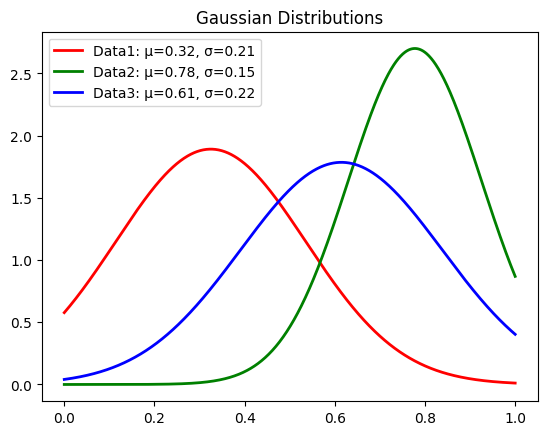

In [29]:
from scipy.stats import norm

def plot_gaussian(data1, data2, data3):
    print(data1, data2, data3)
    # 각 데이터셋에 대한 평균과 표준편차를 계산
    mu1, std1 = np.mean(data1), np.std(data1)
    mu2, std2 = np.mean(data2), np.std(data2)
    mu3, std3 = np.mean(data3), np.std(data3)

    # 모든 데이터의 범위를 기반으로 x 값들을 샘플링
    xmin = min(min(data1), min(data2), min(data3))
    xmax = max(max(data1), max(data2), max(data3))
    x = np.linspace(0, 1, 1000)

    # 확률 밀도 함수 값을 계산
    p1 = norm.pdf(x, mu1, std1)
    p2 = norm.pdf(x, mu2, std2)
    p3 = norm.pdf(x, mu3, std3)

    # 그래프 그리기
    plt.plot(x, p1, 'r', linewidth=2, label=f"Data1: µ={mu1:.2f}, σ={std1:.2f}")
    plt.plot(x, p2, 'g', linewidth=2, label=f"Data2: µ={mu2:.2f}, σ={std2:.2f}")
    plt.plot(x, p3, 'b', linewidth=2, label=f"Data3: µ={mu3:.2f}, σ={std3:.2f}")


    plt.title("Gaussian Distributions")
    plt.legend()
    plt.show()

plot_gaussian(*ratios)

In [ ]:
for i in range(n_clusters):
  cluster_info = {}
  l, r = clustered_count[i][0], clustered_count[i][1]
  cluster_info['name'] = f'Cluster #{i+1}'
  cluster_info['value'] = l + r
  cluster_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]

  topics_list = []
  for j in range(len(clustered_topics[i])):
    topic_info = {}
    k = clustered_topics[i][j]
    l, r = table[int(k)][0], table[int(k)][1]
    topic_info['name'] = clustered_topics_name[i][j]
    topic_info['value'] = l + r
    topic_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]
    topics_list.append(topic_info)

  cluster_info['topics'] = topics_list
  clusters.append(cluster_info)

In [ ]:
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


def showDistribution(n, verify, selected_topic_names, post_counts, embed_ids, hierarchical_topics, embeddings):
  n_clusters=n
  kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings)

  clustered_topics = [[] for _ in range(n_clusters)]
  clustered_topics_name = [[] for _ in range(n_clusters)]
  clustered_topics_count = [[] for _ in range(n_clusters)]

  for i, label in enumerate(kmeans.labels_):
    clustered_topics[label].append(embed_ids[i])
    clustered_topics_name[label].append(selected_topic_names[i])
  for r in clustered_topics_name:
    print(r)

  cluster_sums = []
  for idx, cluster in enumerate(clustered_topics):
    total_sum = 0
    for parent_id in cluster:
      row = hierarchical_topics[hierarchical_topics['Parent_ID'] == parent_id].iloc[0]
      topic_ids = row['Topics']
      cluster_sum = sum(post_counts[topic_id] for topic_id in topic_ids)
      clustered_topics_count[idx].append(cluster_sum)
      total_sum += cluster_sum
    cluster_sums.append(total_sum)
  print(cluster_sums)
  if verify:
    clustered_count = [[0, 0] for _ in range(n_clusters)]
    for i in range(n_clusters):
      for j in clustered_topics[i]:
        clustered_count[i][0] += table[int(j)][0]
        clustered_count[i][1] += table[int(j)][1]

    for i in range(n_clusters):
      l, r = clustered_count[i][0], clustered_count[i][1]
      # print(f'Cluster #{i+1}: ({l + r}) - [{100 * l / (l + r):.2F}, {100 * r / (l + r):.2F}]')
      for j in range(len(clustered_topics[i])):
        k = clustered_topics[i][j]
        l, r = table[int(k)][0], table[int(k)][1]
        # print(f'\t- {clustered_topics_name[i][j]} ({l + r}): [{100 * l / (l + r):.2F}, {100 * r / (l + r):.2F}]')
    clusters = []

    for i in range(n_clusters):
      cluster_info = {}
      l, r = clustered_count[i][0], clustered_count[i][1]
      cluster_info['name'] = f'Cluster #{i+1}'
      cluster_info['value'] = l + r
      cluster_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]

      topics_list = []
      for j in range(len(clustered_topics[i])):
        topic_info = {}
        k = clustered_topics[i][j]
        l, r = table[int(k)][0], table[int(k)][1]
        topic_info['name'] = clustered_topics_name[i][j]
        topic_info['value'] = l + r
        topic_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]
        topics_list.append(topic_info)

      cluster_info['topics'] = topics_list
      clusters.append(cluster_info)

    font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=10)
    plt.rcParams["font.family"] = fontprop.get_name()
    plt.rcParams['axes.unicode_minus'] = False

    def sort_topics_by_distribution(cluster):
      cluster['topics'] = sorted(cluster['topics'], key=lambda x: x['distribution'][0], reverse=True)

    for cluster in clusters:
      print(cluster)
      sort_topics_by_distribution(cluster)

    fig, ax = plt.subplots(figsize=(10, 6))

    y_positions = []
    y_labels = []

    current_y = 0
    bar_width = 0.4

    for cluster in clusters:
      y_positions.append(current_y)
      y_labels.append(cluster['name'])
      for topic in cluster['topics']:
        current_y -= 1
        y_positions.append(current_y)
        y_labels.append(topic['name'])
        ax.barh(current_y, topic['distribution'][0], color='r', height=bar_width, label=topic['name'])
        ax.barh(current_y, topic['distribution'][1], color='g', left=topic['distribution'][0], height=bar_width)
      current_y -= 2

    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels, fontproperties=fontprop)
    ax.set_xlabel('커뮤니티 분포', fontproperties=fontprop)
    plt.title("FastText 이용 클러스터링 결과", fontproperties=fontprop)
    plt.ylabel("토픽 이름", fontproperties=fontprop)

    plt.tight_layout()
    plt.show()
    return clustered_topics_name, clustered_topics_count, kmeans, clustered_topics

['꽃이']
['뿌리가', '사진', '우리집', '이거', '기니피그', '서울', '에어컨', '제라늄', '피그미다람쥐', '잠자는쥐', '코코넛', '일본', '고양이', '토마토', '로보쿤', '유혈목이', '이름이', '알로카시아', '쥐친구', '아몬드', '나무위키', '햄스터', '신엽']
['냄새', '식물', '버섯', '돼지']
[4066, 13195, 1752]
{'name': 'Cluster #1', 'value': 4066, 'distribution': [12.739793408755533, 87.26020659124447], 'topics': [{'name': '꽃이', 'value': 4066, 'distribution': [12.739793408755533, 87.26020659124447]}]}
{'name': 'Cluster #2', 'value': 13195, 'distribution': [59.94694960212202, 40.05305039787798], 'topics': [{'name': '뿌리가', 'value': 650, 'distribution': [3.8461538461538463, 96.15384615384616]}, {'name': '사진', 'value': 263, 'distribution': [59.6958174904943, 40.3041825095057]}, {'name': '우리집', 'value': 510, 'distribution': [76.27450980392157, 23.725490196078432]}, {'name': '이거', 'value': 1244, 'distribution': [62.37942122186495, 37.62057877813505]}, {'name': '기니피그', 'value': 183, 'distribution': [87.43169398907104, 12.568306010928962]}, {'name': '서울', 'value': 323, 'distribution': 

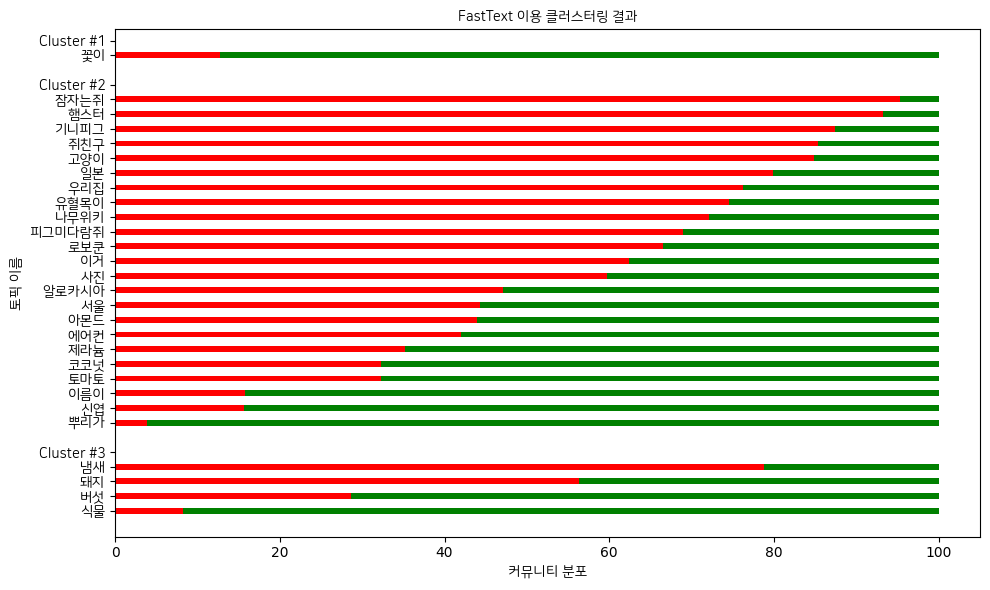

In [ ]:
clustered_topics_name, clustered_topics_count, kmeans, clustered_topics = showDistribution(3, verify, selected_topic_names, post_counts, embed_ids, hierarchical_topics, embeddings)

In [ ]:
for r in zip(clustered_topics_name, clustered_topics_count):
  print(r)

(['꽃이'], [4066])
(['뿌리가', '사진', '우리집', '이거', '기니피그', '서울', '에어컨', '제라늄', '피그미다람쥐', '잠자는쥐', '코코넛', '일본', '고양이', '토마토', '로보쿤', '유혈목이', '이름이', '알로카시아', '쥐친구', '아몬드', '나무위키', '햄스터', '신엽'], [650, 263, 510, 1244, 183, 323, 243, 213, 235, 148, 1275, 114, 575, 369, 1203, 173, 782, 276, 299, 157, 111, 3197, 652])
(['냄새', '식물', '버섯', '돼지'], [444, 1060, 122, 126])


In [ ]:
# import fasttext
# from sklearn.cluster import KMeans
# import numpy as np

# def find_similar_words(word_list, weights, model, top_n=1):
#     vectors = [model.wv[word] for word in word_list]
#     avg_vector = np.average(vectors, axis=0,weights=weights)
#     # avg_vector = np.mean(vectors, axis=0)
#     similar_words = model.wv.similar_by_vector(avg_vector)
#     return [word[0] for word in similar_words]
# n_clusters=3
# for i in range(n_clusters):
#   print(f'{find_similar_words(clustered_topics_name[i], clustered_topics_count[i], m_fasttext)[0]}: {sum(clustered_topics_count[i])}')


꽃이: 4066
햄스터: 13195
식물: 1752


In [ ]:
def show(cname):
  for i in range(3):
    print(sorted(cname[i]))

In [ ]:
show(cRatio)

['고양이', '기니피그', '나무위키', '냄새', '우리집', '유혈목이', '일본', '잠자는쥐', '쥐친구', '햄스터']
['꽃이', '버섯', '뿌리가', '식물', '신엽', '이름이']
['돼지', '로보쿤', '사진', '서울', '아몬드', '알로카시아', '에어컨', '이거', '제라늄', '코코넛', '토마토', '피그미다람쥐']


In [ ]:
show(clustered_topics_name)

['꽃이']
['고양이', '기니피그', '나무위키', '로보쿤', '뿌리가', '사진', '서울', '신엽', '아몬드', '알로카시아', '에어컨', '우리집', '유혈목이', '이거', '이름이', '일본', '잠자는쥐', '제라늄', '쥐친구', '코코넛', '토마토', '피그미다람쥐', '햄스터']
['냄새', '돼지', '버섯', '식물']
